<a href="https://colab.research.google.com/github/CodeHunterOfficial/Practical-Time-Series-Analysis/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%81%D1%80%D0%B5%D0%B4%D1%81%D1%82%D0%B2%D0%B0%D0%BC%D0%B8_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Прогнозирование средствами Python ([f2forecast](https://www.youtube.com/playlist?list=PLPOd75yy4sZsbsx1HKW2puOCWx1JXFqHx))

Первым делом устанавливаем библиотеку adtk.

## Набор инструментов для обнаружения аномалий (ADTK)

Anomaly Detection Toolkit (ADTK) — это пакет Python для неконтролируемого или основанного на правилах обнаружения аномалий временных рядов.

Поскольку природа аномалии различается в разных случаях, модель может не работать универсально для всех проблем обнаружения аномалий. Правильный выбор и сочетание алгоритмов обнаружения (детекторов), методов разработки признаков (преобразователей) и ансамблевых методов (агрегаторов) является ключом к построению эффективной модели обнаружения аномалий.

Этот пакет предлагает набор общих детекторов, преобразователей и агрегаторов с унифицированными API, а также классы каналов, которые соединяют их вместе в модель. Он также предоставляет некоторые функции для обработки и визуализации временных рядов и аномальных событий.


### https://adtk.readthedocs.io/en/stable/

In [ ]:
!pip install adtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 5.5 MB/s 


## Pmdarima 

Pmdarima (первоначально pyramid-arimaдля анаграммы «py» + «arima») — это статистическая библиотека, предназначенная для заполнения пробела в возможностях анализа временных рядов Python. Это включает:

*  Эквивалент auto.arimaфункциональности R
*  Сборник статистических тестов стационарности и сезонности
*  Утилиты временных рядов, такие как разность и обратная разность
*  Многочисленные эндогенные и экзогенные преобразователи и функции, включая преобразования Бокса-Кокса и Фурье.
*  Сезонные разложения временных рядов
*  Утилиты перекрестной проверки
*  Богатая коллекция встроенных наборов данных временных рядов для прототипирования и примеров
*  Конвейеры в стиле Scikit-learn для консолидации ваших оценок и продвижения производства
*   Pmdarima скрывает статистические модели под капотом, но разработан с интерфейсом, знакомым пользователям, имеющим опыт научного обучения.

Установим библиотеку

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 15.5 MB/s 
     |████████████████████████████████| 9.8 MB 50.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


### https://pypi.org/project/pmdarima/

В следующем коде импортируются необходимые библиотеки, а кроме того, пишутся другие вспомогательные функции.

In [ ]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
#import time

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
#from sklearn.metrics import r2_score

from scipy.stats import variation

import seaborn as sns

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

#from dateutil.parser import parse

#import itertools
from itertools import compress, product

#import pmdarima as pm
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

# функция графика сезонности
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()
    
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стационарность:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значение = {:.3f}".format(dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные {} стационарны с вероятностью {}% процентов".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    #real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    

def metrics_short(real, forecast):
    real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    
def h_map(data, level):
    corr = data.corr()
    plt.figure(figsize=(14, 14))
    sns.heatmap(corr[(corr >= level) | (corr <= -level)],
            cmap="RdBu_r", vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
    plt.show()
    
#небольшая функция для построения набора комбинаций переменных
def combinations(items):
    return list( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )

def get_factors(data, Y, columns):

    # колонки, которые показали свою значимость в процессе отбора критериев
    # переменная spisCol хранит варианты комбинаций все переменных
    spisCol=combinations(columns)

    print('Количество комбинаций ', len(spisCol))
    
    #добавим константу в набор данных, нужна для рассчета регрессии
    data=sm.add_constant(data)

    #сохраним в этом списке данные лучших моделей
    arr_res=[]

    #пробежимся циклом по всем вариантам комбинаций
    for c in spisCol:
        perem=list(c)
        flag=True
    
        if len(perem)==0: continue
        
        if not('const' in c):
            perem.append('const')
        
        # если больше одного клитерия, рассчитаем VIF    
        if len(perem)>1:
            vif = [variance_inflation_factor(data[perem].values, i) for i in range(data[perem].shape[1])]
        else:
            vif=[]
    
        #проверим список VIF, если хоть одна переменная больше 1000 (очень большое значение, на самом деле),
        #то в модели присутсвует мультиколлинераность
        for vv in vif:
            if vv>1000: 
                flag=False
        
        #посчитаем саму модель
        reg = sm.OLS(Y, data[perem])
        res=reg.fit()

        #отбросим нулевую гипотезу для всех регрессоров конкретной модели
        for val in res.tvalues:
            if val<2 and val>-2:
                flag=False
                break
        for val in res.pvalues:
            if val>0.05:
                flag=False
                break
        #если нулевую гипотезу отбросили и VIF в норме, сохраним результаты
        if flag:
            re=np.array(res.fittedvalues.copy())
            MSE=((np.array(Y)-re)**2).sum()/len(re)
            
            MAPE=(abs((np.array(Y)-re)/np.array(Y))).sum()/len(re)
        
            arr_res.append([round(MSE,4), res.rsquared, perem])

    #отсортируем и выведем результаты
    arr_res.sort()
    df_model=pd.DataFrame(arr_res, columns=['MSE', 'r2', 'Переменные'])
    print('Результаты перебора в порядке возрастания MSE:')
    print(df_model)
    return df_model

ModuleNotFoundError: ignored

In [ ]:
!python /content/f2forecast.py

Traceback (most recent call last):
  File "/content/f2forecast.py", line 6, in <module>
    from adtk.data import validate_series
ModuleNotFoundError: No module named 'adtk'


Теперь подключаем файл Excel к проекту. Обратите внимание, что ваши данные также были такими.

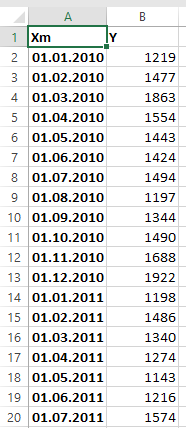

Т. е. должно быть два столбца: значение даты, отсортированное по возрастанию, которое используется в качестве индекса,  значение. Название стольбца должно быть такие Xm и Y.

#### Совет. Если книга Excel имеет один лист, то название листа указывать не нужно. 

In [ ]:
import pandas as pd
import numpy as np


Читаем файл с данными (лист 'Data').

In [ ]:
df=pd.read_excel("sample_dataset.xlsx", index_col='Xm', sheet_name='Data')
df.head()

,Y
Xm,
2015-01-01,1388
2015-02-01,1088
2015-03-01,1813
2015-04-01,1523
2015-05-01,1595


In [ ]:
df.tail()

,Y
Xm,
2018-12-01,1777
2019-01-01,1536
2019-02-01,1190
2019-03-01,1530
2019-04-01,1840


Исходный набор содержит данные по месяцам с января 2015 года по апрель 2019 года.

Выполним валидацию данных и выведем на экран значения.

In [ ]:
df = validate_series(df)
print(df)

               Y
Xm              
2015-01-01  1388
2015-02-01  1088
2015-03-01  1813
2015-04-01  1523
2015-05-01  1595
2015-06-01  1475
2015-07-01  1657
2015-08-01  1506
2015-09-01  1208
2015-10-01  1506
2015-11-01  1544
2015-12-01  1583
2016-01-01   997
2016-02-01  1264
2016-03-01  1238
2016-04-01  1370
2016-05-01  1305
2016-06-01  1351
2016-07-01  1603
2016-08-01  1433
2016-09-01  1343
2016-10-01  1430
2016-11-01  1555
2016-12-01  1663
2017-01-01  1090
2017-02-01  1047
2017-03-01  1608
2017-04-01  1263
2017-05-01  1482
2017-06-01  1921
2017-07-01  1905
2017-08-01  1991
2017-09-01  1072
2017-10-01  2054
2017-11-01  1616
2017-12-01  1192
2018-01-01  1249
2018-02-01  1453
2018-03-01  2200
2018-04-01  2024
2018-05-01  2268
2018-06-01  1902
2018-07-01  2150
2018-08-01  2016
2018-09-01  1679
2018-10-01  1670
2018-11-01  1726
2018-12-01  1777
2019-01-01  1536
2019-02-01  1190
2019-03-01  1530
2019-04-01  1840


Построим график по месяцам на всем периоде.

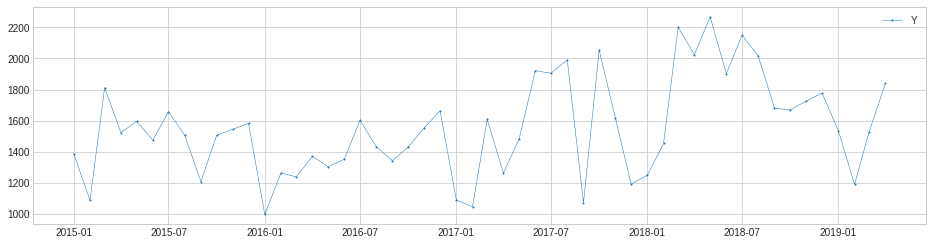

In [ ]:
plot(df)

Посмотрим основные статистики ряда данных.

In [ ]:
df.describe()

,Y
count,52.000000
mean,1555.557692
std,315.367847
min,997.000000
25%,1333.500000
50%,1533.000000
75%,1738.750000
max,2268.000000


Среднее значение набора не очень близко к медиане, что позволяет нам говорить о нормальном распределении значений.

Посмотрим на точки, которые легли выше 2200 контейнеров и ниже 1000 контейнеров. Потенциально эти значения могут быть выбросами.

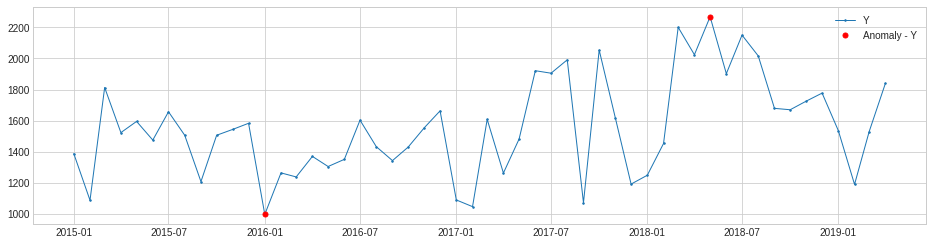

In [ ]:
threshold_ad = ThresholdAD(high=2200, low=1000)
anomalies = threshold_ad.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [ ]:
anomalies[anomalies.Y]

,Y
Xm,
2016-01-01,True
2018-05-01,True


Аномалии пришлись на две точки. Потенциально в мае 2018 года может быть выброс. Этот период надо изучить детальнее.

### Представляем обнаружение аномалий/выбросов в Python с помощью PyOD 🔥
#### https://towardsdatascience.com/introducing-anomaly-outlier-detection-in-python-with-pyod-40afcccee9ff


Посмотрим на выбросы при помощи метода OutlierDetector и попробуем менять уровень значимости от 0.01 до 0.1.

In [ ]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.01))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', curve_group='all', anomaly_alpha=0.1);

NameError: ignored

In [ ]:
anomalies[anomalies]

Xm
2017-10-01    True
2018-03-01    True
2018-05-01    True
2018-07-01    True
dtype: bool

Мы видим, что есть все признаки выброса в периоде первой половины 2018 года. Для окончательного заключения изучим отклонения в сезонной компоненте.

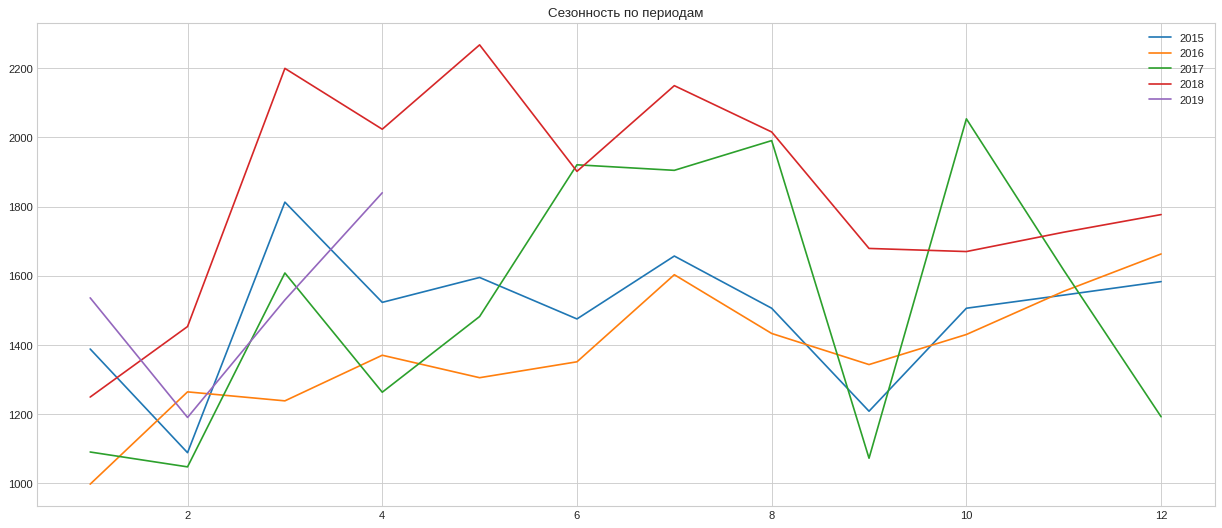

In [ ]:
sesonal(df,12) #количество периодов в году, в данном случае строим по месяцам

Изучив фактические данные и результаты анализа на выбросы, делаем заключение, что выбросы есть в четырех периодах: 03-05.2018 и 07.2018. Первую точку возьмем по аналогии с 2015 годом: на сезонном графике видно, что динамика этих лет примерно совпадает. А вторую возьмем по аналогии с 07.2017 года.

Методические рекомендации: постарайтесь подробнее расписать причины отклонений и почему выбрали именно эти точки в выбросах.

In [ ]:
df.loc['2018-03-01'].Y=df.loc['2015-03-01'].Y
df.loc['2018-04-01'].Y=df.loc['2015-04-01'].Y
df.loc['2018-05-01'].Y=df.loc['2015-05-01'].Y
df.loc['2018-07-01'].Y=df.loc['2017-07-01'].Y

Оценим результаты корректировок.

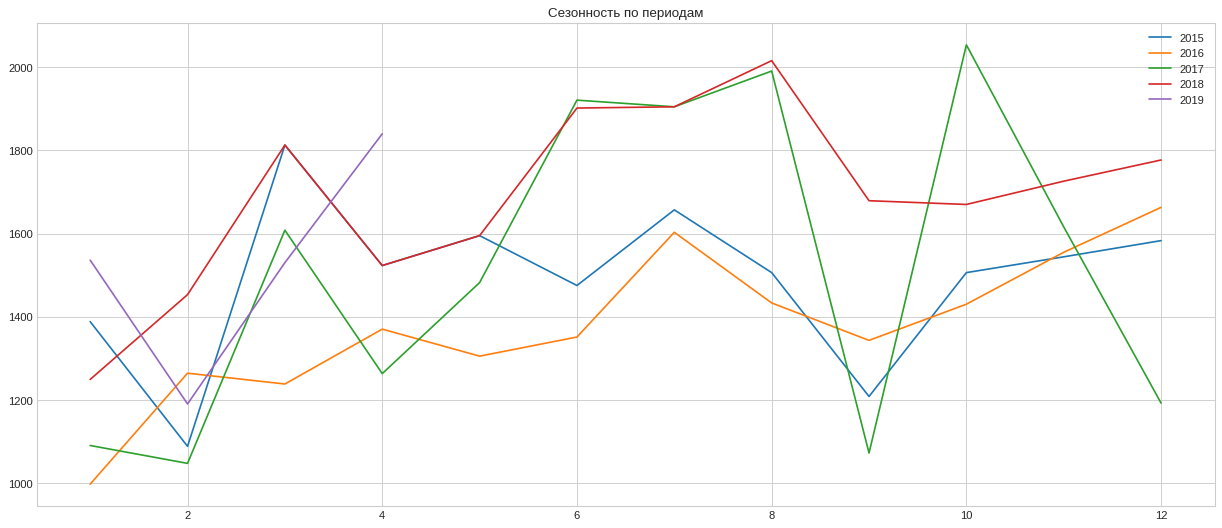

In [ ]:
sesonal(df,12)

#Декомпозиция: тренд и сезонность

Оценим стабильность тренда, сезонности и возможность использования всего ряда данных.

Оценим ряд через мультипликативную представленность.

Text(0.5, 0.98, 'Мультипликативная модель')

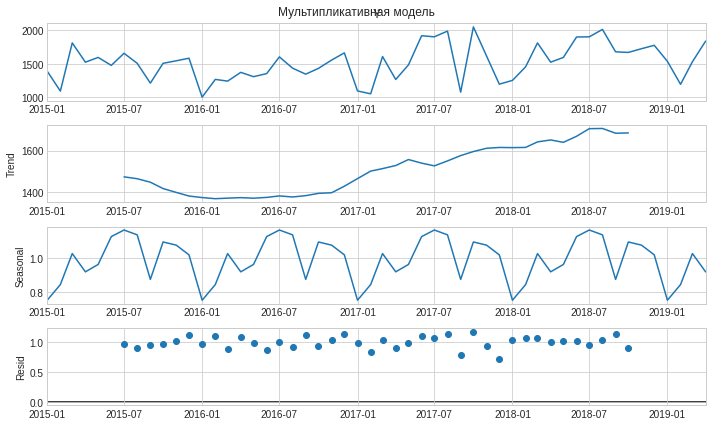

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# декомпозиция 
result_M = seasonal_decompose(df.Y, model='multiplicative')

# Построение графика
plt.rcParams.update({'figure.figsize': (10,6)})
result_M.plot().suptitle('Мультипликативная модель')

Аддитивное разложение ряда.

Text(0.5, 0.98, 'Аддитивная модель')

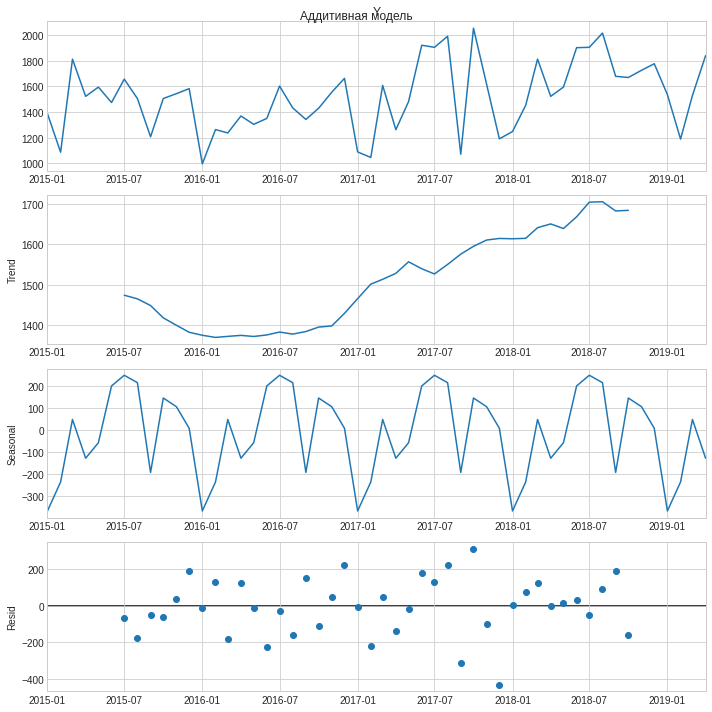

In [ ]:
# Decompose 
result_A = seasonal_decompose(df.Y, model='additive')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Аддитивная модель')

Несмотря на небольшой слом тренда, будем использовать полный набор данных. Если не сможем обеспечить необходимую точность и алгоритмы не смогут "отловить" слом, можем перейти к использованию данных только с 2016 года. Ограниченный набор данных в этом случае не позволит выделить тестовую выборку.

Также, скорее всего, оптимальнее будет мультипликативная модель ряда, так как она демонстрирует более пологий тренд и меньший разброс остатков.

**Методические указания:** постарайтесь найти ряд за пять и более лет.

## 03 Тестовые и тренировочные наборы данных

Мы научимся с вами делить данные на две части: тестовые и тренировочные. Для чего это нужно? Сейчась обсудим.  Очень часто модели и переобучаются на тех данных которые есть она хорошо описывает данные но обладает слабой прогностической способностью,  и в данном случае мы будем тестировать модель пряча от неё часть данных уже известно для нас, тренировочную часть как правило тестовая часть это кусочек там до 20% от всего набора данных на котором как раз и будем проверять нашу модель. 
Давайте для этого создадим переменную Train которые мы присваиваем значение нашей модели начиная с 2014 года ни на модели  фактических данных с 2014 года по 2018 год, то есть мы не будем использовать мы рассуждали чуть раньше почему не сопоставимые данные с 2010 по 2013 начинаем использовать данные 2014 года по медали А вот данные как раз 2019 года 7 месяцев которые у нас есть мы будем с вами использовать как тестовые и на них будем проверять Какая из моделей точнее предсказывает? Именно эту модель которой обладает лучшие прогностической способности мы будем использовать. Конечно перед боевым применением выбранную модель обучим на всем известном наборе данных и уже её будем использовать как раз для прогнозирования будущих периодов. Давайте выведем значение первых  5 значение нашей модели нашей переменной уже train.  это наш тренировочный набор данных будет. Дальше мы приступаем непосредственно к прогнозированию.

**Тренировочные и тестовые данные**

Разделим данные на тренировочные и тестовые. В качестве тестовых возьмем результаты января-апреля 2019 года.

**Методические указания: **тестовые данные обычно составляют от 5% до 20% от всего набора.

In [ ]:
train=df[:'2018']
train.head()

,Y
Xm,
2015-01-01,1388
2015-02-01,1088
2015-03-01,1813
2015-04-01,1523
2015-05-01,1595


In [ ]:
test=df['2019':]
test.head()

,Y
Xm,
2019-01-01,1536
2019-02-01,1190
2019-03-01,1530
2019-04-01,1840


### 04 Модель Хольта Винтерса